In [ ]:
import xarray as xr
import data_types
import importlib
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
import seaborn
rng = np.random.default_rng()

year=2020
data_dir = '/scratch/cimes/feiyul/Ocean_Data'
# data_dir = '/collab1/data_untrusted/Feiyu.Lu/Ocean_Data'

model_dz_ds = xr.open_dataset(f'{data_dir}/model_data/M9/vgrid_75_2m.nc')
model_dz = model_dz_ds.dz
model_zi = np.zeros(len(model_dz)+1)
for i in range(1,len(model_dz)+1):
    model_zi[i] = model_dz[0:i].sum().values

argo_obs_ds = xr.open_dataset(f'{data_dir}/obs_data/argo/argo_{year}.nc')

In [ ]:
importlib.reload(data_types)
print(len(argo_obs_ds.station_index))
argo_obs = data_types.argo(argo_obs_ds,nread=100000,year=year)
print(len(argo_obs))

1068126
6195


2024-05-09T18:05:37.500000256 8.806 235.436


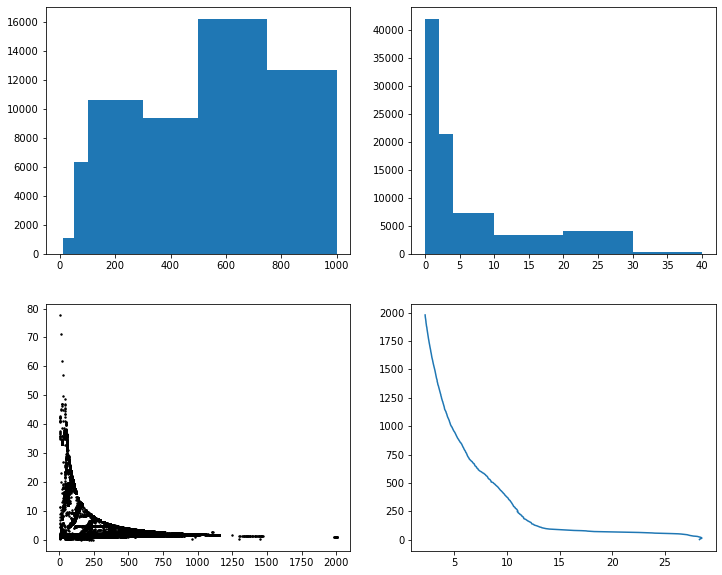

In [4]:
fig, axes = plt.subplots(2,2,figsize=(12,10))

axes[0,0].hist(argo_obs.levels,[0,10,50,100,300,500,750,1000])

axes[0,1].hist((argo_obs.max_depth-argo_obs.min_depth)/argo_obs.levels,[0,2,4,10,20,30,40])

axes[1,0].scatter(
    argo_obs.levels,
    (argo_obs.max_depth-argo_obs.min_depth)/argo_obs.levels,
    s=2,color='black')

i = rng.integers(0,len(argo_obs))
print(argo_obs.time[i],argo_obs.lat[i],argo_obs.lon[i])
# print(argo_obs.profiles[i].depth)
# print(argo_obs.profiles[i].levels)
axes[1,1].plot(argo_obs.profiles[i].T, argo_obs.profiles[i].depth)

In [5]:
combine_levels = range(0,len(model_dz)+1,3)
model_dz_coarse, model_z_coarse = data_types.depth_vertical_coarsen(model_dz,combine_levels)
model_z_argo = model_z_coarse[model_z_coarse<2000]
print(model_z_argo)

[   3.       9.01    15.07    21.29    27.865   35.11    43.53    53.915
   67.535   86.48   114.14   155.935  220.27   319.36   469.39   689.15
  996.58  1403.68  1911.79 ]


In [6]:
importlib.reload(data_types)
argo_obs_interp = data_types.argo(argo_obs_ds,interp=True,target_depth=model_z_argo)
len(argo_obs_interp)

79119

2024-01-25T07:24:22.499999744 -34.03 194.173


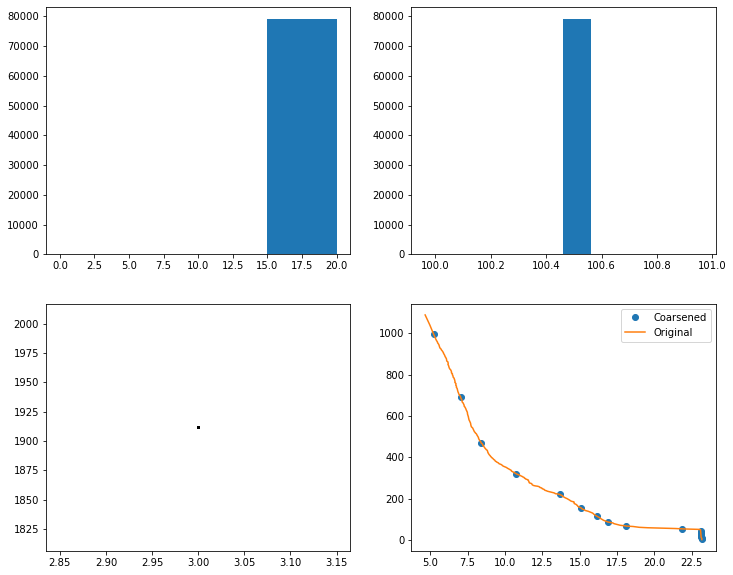

In [15]:
fig, axes = plt.subplots(2,2,figsize=(12,10))

axes[0,0].hist(argo_obs_interp.levels,[0,5,10,15,20])

axes[0,1].hist((argo_obs_interp.max_depth-argo_obs_interp.min_depth)/argo_obs_interp.levels)

axes[1,0].scatter(
    argo_obs_interp.min_depth,
    argo_obs_interp.max_depth,
    s=2,color='black')

i = rng.integers(0,len(argo_obs_interp))
print(argo_obs_interp.time[i],argo_obs_interp.lat[i],argo_obs_interp.lon[i])
# print(argo_obs_interp.profiles[i].depth)
# print(argo_obs_interp.profiles[i].levels)
axes[1,1].plot(argo_obs_interp.profiles[i].T, argo_obs_interp.profiles[i].depth,'o',label="Coarsened")
axes[1,1].plot(argo_obs.profiles[i].T, argo_obs.profiles[i].depth,label="Original")
axes[1,1].legend()

In [16]:
ds=argo_obs_interp.convert_interpolated_to_dataset()

In [ ]:
ds.to_netcdf(f'{data_dir}/obs_data/argo/argo_{year}_interp.nc')